In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange
    
from torchvision.ops import nms
from helper.drawer import *

In [2]:
# Test code

# samples = 4

# for _ in range(samples):
#     random_sample = randrange(len(annotations))
#     filepath, annotation = annotations[random_sample]

#     image = Image.open(filepath)
#     image = draw_cell_boundaries(image, cells=7)
#     image = draw_center_cell_object(image, annotator, annotation, cells=7)
    
#     plt.figure(figsize=(15, 15))
#     plt.imshow(np.asarray(image))

# Prepare dataset and training
- Create random 5-image batch and pass it through model.
- We will evaluate loss via result image and intermediate output console

In [3]:
%matplotlib inline

from maintrainer.dataset import VOCYOLOAnnotator, VOCYolo

annotator = VOCYOLOAnnotator(
    annotation_root=r'C:\Dataset\VOCdevkit\VOC2008\Annotations',
    image_root=r'C:\Dataset\VOCdevkit\VOC2008\JPEGImages'
#     annotation_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/Annotations',
#     image_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

print(annotator.labels)

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: C:\Dataset\VOCdevkit\VOC2008\JPEGImages\2007_000027.jpg
Annotation[1]: [[14, 3, 3, 0.7664609053497946, 0.16400000000000015, 0.360082304526749, 0.5]]
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [4]:
import torchvision.transforms
from torchvision.transforms import *
import albumentations as A

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ]),
    augmentations=[
        A.PadIfNeeded(min_width=448, min_height=448),
        A.RandomCrop(width=448, height=448),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2)
    ]
)

inline_transform = transforms.Normalize(
    mean=[0.4547857, 0.4349471, 0.40525291],
    std=[0.12003352, 0.12323549, 0.1392444]
)

batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True)

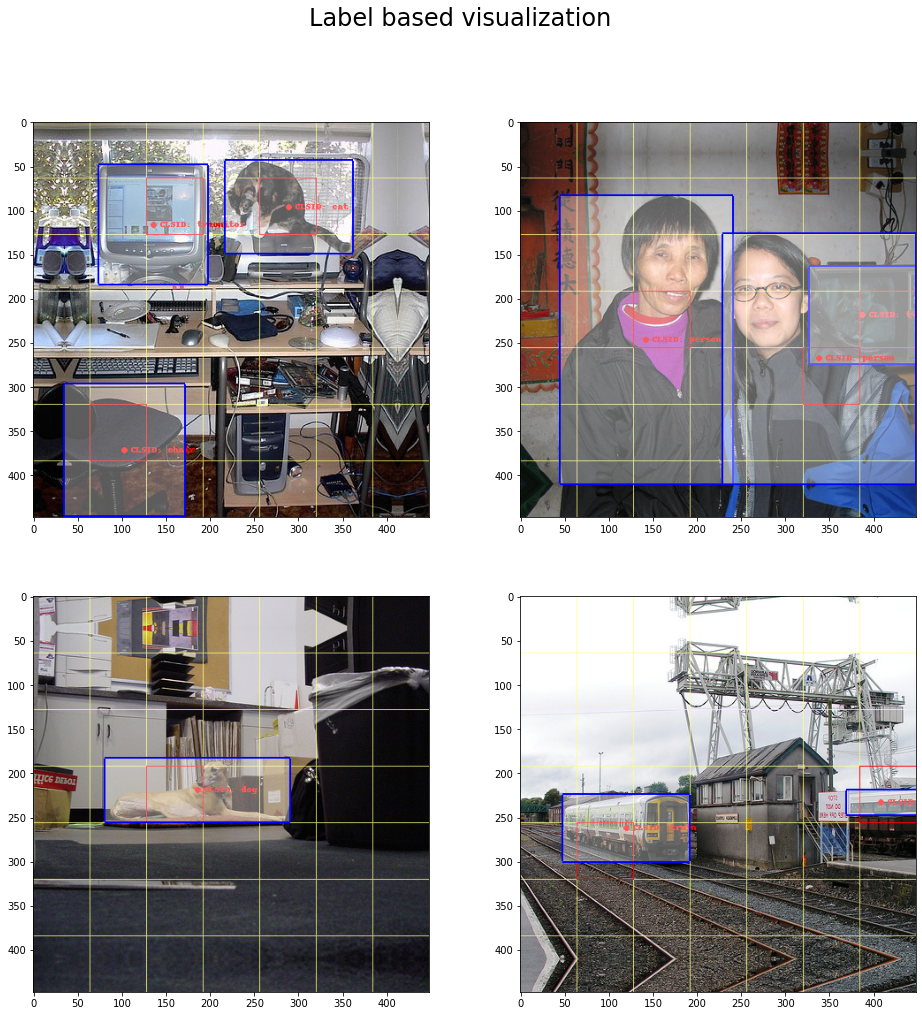

In [5]:
bunch_of_batch = []
for i, item in enumerate(train_dataloader):
    if i >= 4:
        break
    bunch_of_batch.append(item)

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Label based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image[:1, :, :, :])
    label = torch.squeeze(label[:1, :, :, :])
    
    image = (image.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.cpu().numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object_label(image, annotator, label)
    ax.imshow(np.array(image))
    
plt.show()

In [6]:
def do_visualization(batched_image = None, batched_label = None, title = None, confidence_threshold = 0.8,
                    subplot_size = (2, 2)):
    if subplot_size == (1, 4):
        fig = plt.figure(figsize=(20, 5))
    elif subplot_size == (2, 2):
        fig = plt.figure(figsize=(20, 20))
        
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    
    if batched_image is None or batched_label is None:
        batched_image = torch.cat([image[:1, :, :, :].cuda(non_blocking=True) for image, label in bunch_of_batch], 0)
        batched_label = torch.cat([label[:1, :, :, :] for image, label in bunch_of_batch], 0)
    
    output = model(inline_transform(batched_image)).detach().cpu()
    output_images = []
    for i in range(output.shape[0]):
        output_images.append(output[i:i+1, :, :, :])
    
    for i, output in enumerate(output_images):
        ax = fig.add_subplot(*subplot_size, i + 1)

        image = torch.squeeze(batched_image[i].cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=confidence_threshold)
        ax.imshow(np.array(image))
    model.train()

    plt.show()

In [7]:
from maintrainer.loss import YoloLoss
from model import YOLOv1, YOLOv1Pretrainer
import random
import os

PRETRAINED_WEIGHT = r'C:\Workspace\study-projects\yolov1-torch\prepare-torch\.pretrained\2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'
# PRETRAINED_WEIGHT = '.checkpoints/2021-06-16-10-44-40_FullDataset-LRDecay-Continued-From-22epoch-LowerLR_LR0.000250_BS064_WORKERS16_EPOCHS200_GPU-epoch0043-train_loss1.512860-val_loss1.674705-val_acc0.616029-val_acct50.832321.zip'

if not os.path.isfile(PRETRAINED_WEIGHT):
    print("Pretrained weight file %s not found!" % PRETRAINED_WEIGHT)
    exit(-1)

checkpoint = torch.load(PRETRAINED_WEIGHT)
# c_epoch = checkpoint['epoch'] + 1
c_model_state_dict = checkpoint['model_state_dict']
# c_optimizer_state_dict = checkpoint['optimizer_state_dict']
# c_loss = checkpoint['loss']

pretrainer = YOLOv1Pretrainer(classes=1000)
pretrainer.load_state_dict(c_model_state_dict)
model = YOLOv1(pretrainer).cuda().float()
model.enable_features()
del pretrainer

YOLOv1: Loaded pretrained weights from Pretrainer
YOLOv1: Disabled pretrained parameter gradients
YOLOv1: Enabled pretrained parameter gradients


NewYoloLossV9 (CUDA not supported for now)
Begin Training (Batch=4, LR=0.000010) 


  0%|          | 0/1274 [00:00<?, ?it/s]

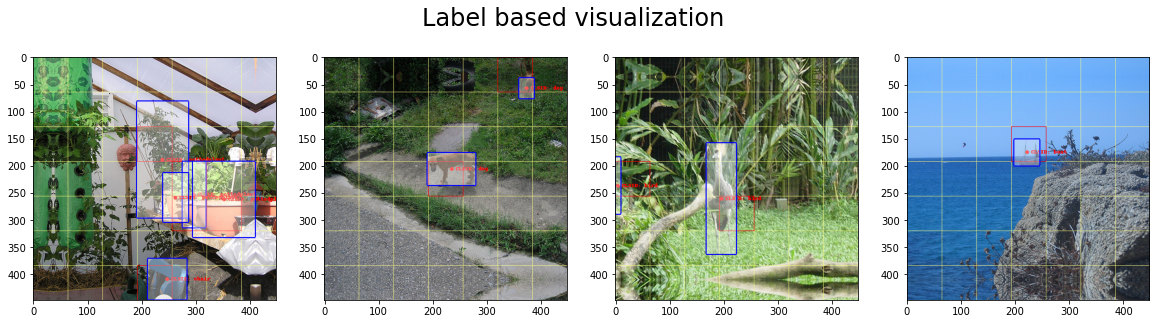

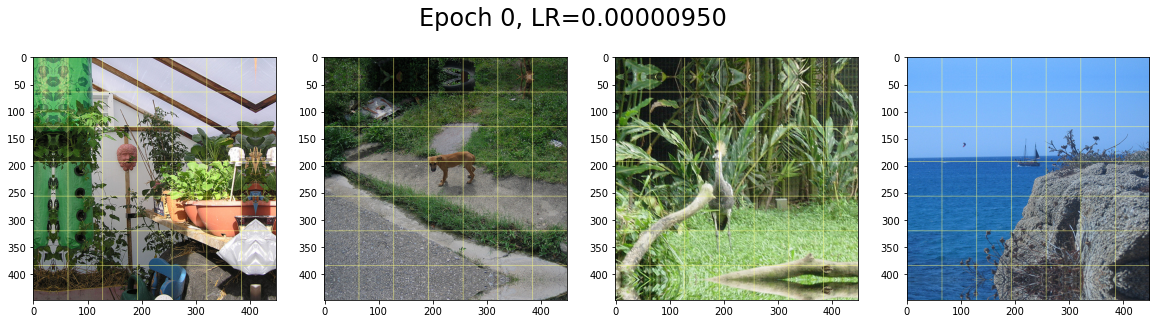

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jungin500\anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-8ff577ed7c23>", line 27, in <module>
    for i, (batched_image, batched_label) in tr:
  File "C:\Users\jungin500\anaconda3\envs\pytorch\lib\site-packages\tqdm\notebook.py", line 254, in __iter__
    for obj in super(tqdm_notebook, self).__iter__():
  File "C:\Users\jungin500\anaconda3\envs\pytorch\lib\site-packages\tqdm\std.py", line 1178, in __iter__
    for obj in iterable:
  File "C:\Users\jungin500\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 517, in __next__
    data = self._next_data()
  File "C:\Users\jungin500\anaconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataloader.py", line 557, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "C:\Users\jungin500\anac

TypeError: object of type 'NoneType' has no len()

In [7]:
from time import sleep
from tqdm.auto import tqdm

# Testing loss with given pseudo output!
visible_criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5, debug=False, visible_output=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # 0.00001, 7e-6

losses = []
xy_losses = []
wh_losses = []
conf_obj_losses = []
conf_noobj_losses = []
class_losses = []

class_accuracies = []
class_top_5_accuracies = []

print("Begin Training (Batch=%d, LR=%.6f) " % (batch_size, optimizer.param_groups[0]['lr']))
for epoch in range(150):
    tr = tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    )
    if epoch % 5 == 0:
        for g in optimizer.param_groups:
            g['lr'] *= 0.95
            
    for i, (batched_image, batched_label) in tr:
        if i == 0:
            fig = plt.figure(figsize=(20, 5))
            fig.suptitle("Label based visualization", fontsize=24)
            for i in range(4):
                image = batched_image[i, :, :, :]
                label = batched_label[i, :, :, :]
                
                ax = fig.add_subplot(1, 4, i + 1)
                image = torch.squeeze(image)
                label = torch.squeeze(label)

                image = (image.cpu().numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
                label = label.cpu().numpy()

                image = Image.fromarray(image)
                image = draw_cell_boundaries(image)
                image = draw_center_cell_object_label(image, annotator, label)
                ax.imshow(np.array(image))

            plt.show()
            do_visualization(batched_image = batched_image[:4, :, :, :].cuda(),
                             batched_label = batched_label[:4, :, :, :].cuda(),
                             title = "Epoch %d, LR=%.8f" % (epoch, optimizer.param_groups[0]['lr']),
                             confidence_threshold = 0.6,
                             subplot_size=(1, 4))

        if batched_image.device.type != 'cuda':
            batched_image = inline_transform(batched_image).cuda(non_blocking=True)
            batched_label = batched_label.cuda(non_blocking=True)

        output = model(batched_image)
        xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss = visible_criterion(output, batched_label)
#         print("\txy_loss: %.4f wh_loss: %.4f conf_obj_loss: %.4f conf_noobj_loss: %.4f class_loss: %.4f" % (
#             xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss))

        # ignore some of the losses
#         conf_noobj_loss = torch.Tensor([0])[0].cuda()
#         class_loss = torch.Tensor([0])[0].cuda()
        # End Ignore

        xy_losses.append(xy_loss.item())
        wh_losses.append(wh_loss.item())
        conf_obj_losses.append(conf_obj_loss.item())
        conf_noobj_losses.append(conf_noobj_loss.item())
        class_losses.append(class_loss.item())
    
        loss = torch.sum(torch.stack([xy_loss, wh_loss, conf_obj_loss, conf_noobj_loss, class_loss]))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        with torch.no_grad():
            model.eval()
            class_accuracy = torch.sum(
                torch.eq(
                    torch.argmax(torch.softmax(output[:, -20:, :, :], dim=1), dim=1),
                    torch.argmax(batched_label, dim=1)
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            class_top_5_accuracy = torch.sum(
                torch.any(
                    torch.eq(
                        torch.argsort(torch.softmax(output[:, -20:, :, :], dim=1), dim=1)[:, -5:, :, :],
                        torch.argmax(batched_label, dim=1, keepdim=True).repeat(1, 5, 1, 1)
                    ),
                    dim=1
                ) * (batched_label[:, 4, :, :] == 1)
            ) / torch.sum(batched_label[:, 4, :, :])
            losses.append(loss.item())
            class_accuracies.append(class_accuracy.item())
            class_top_5_accuracies.append(class_top_5_accuracy.item())
            # print("Epoch %d: Loss %.6f Acc %.6f AccT5 %.6f" % (epoch, losses[-1], class_accuracies[-1], class_top_5_accuracies[-1]))
            tr.set_description("Epoch %d: Loss %.6f Acc %.1f%% AccT5 %.1f%% xy_loss: %.4f wh_loss: %.4f conf_obj_loss: %.4f conf_noobj_loss: %.4f class_loss: %.4f" % (
                epoch,
                np.average(losses),
                np.average(class_accuracies) * 100,
                np.average(class_top_5_accuracies) * 100,
                np.average(xy_losses), np.average(wh_losses), np.average(conf_obj_losses),
                np.average(conf_noobj_losses), np.average(class_losses)
            ))
            model.train()
